In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2025-01-05 08:27:49.706126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736045869.719325   14798 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736045869.723016   14798 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 08:27:49.739449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('dataset_fall/elderly_body_combined.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.896115,0.065920,0.233467,27.588733,-26.734214,4.394665
1,Falling,-1.868648,0.069582,0.218818,24.292734,-31.861324,6.469924
2,Falling,-1.858577,0.041200,0.200507,22.583697,-38.941618,8.789331
3,Falling,-1.847591,0.032044,0.250862,19.531846,-43.458357,11.108737
4,Falling,-1.869564,0.026551,0.271920,16.602069,-48.097171,10.132145


In [3]:
data.shape

(234894, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234894 entries, 0 to 234893
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   234894 non-null  object 
 1   x_acc   234894 non-null  float64
 2   y_acc   234894 non-null  float64
 3   z_acc   234894 non-null  float64
 4   x_gyr   234894 non-null  float64
 5   y_gyr   234894 non-null  float64
 6   z_gyr   234894 non-null  float64
dtypes: float64(6), object(1)
memory usage: 12.5+ MB


In [5]:
# check for null data
data.isnull().sum()

label    0
x_acc    0
y_acc    0
z_acc    0
x_gyr    0
y_gyr    0
z_gyr    0
dtype: int64

In [6]:
# count the datapoints of different activity
data['label'].value_counts()

label
Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: count, dtype: int64

### Balance this data 

In [7]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234894 entries, 0 to 234893
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   234894 non-null  object 
 1   x_acc   234894 non-null  float64
 2   y_acc   234894 non-null  float64
 3   z_acc   234894 non-null  float64
 4   x_gyr   234894 non-null  float64
 5   y_gyr   234894 non-null  float64
 6   z_gyr   234894 non-null  float64
dtypes: float64(6), object(1)
memory usage: 12.5+ MB


In [9]:
# frame size, Frames per second
Fs = 33

In [10]:
activities = data['label'].value_counts().index

In [11]:
activities

Index(['Walking', 'Running', 'Stairs', 'Sitting', 'Falling'], dtype='object', name='label')

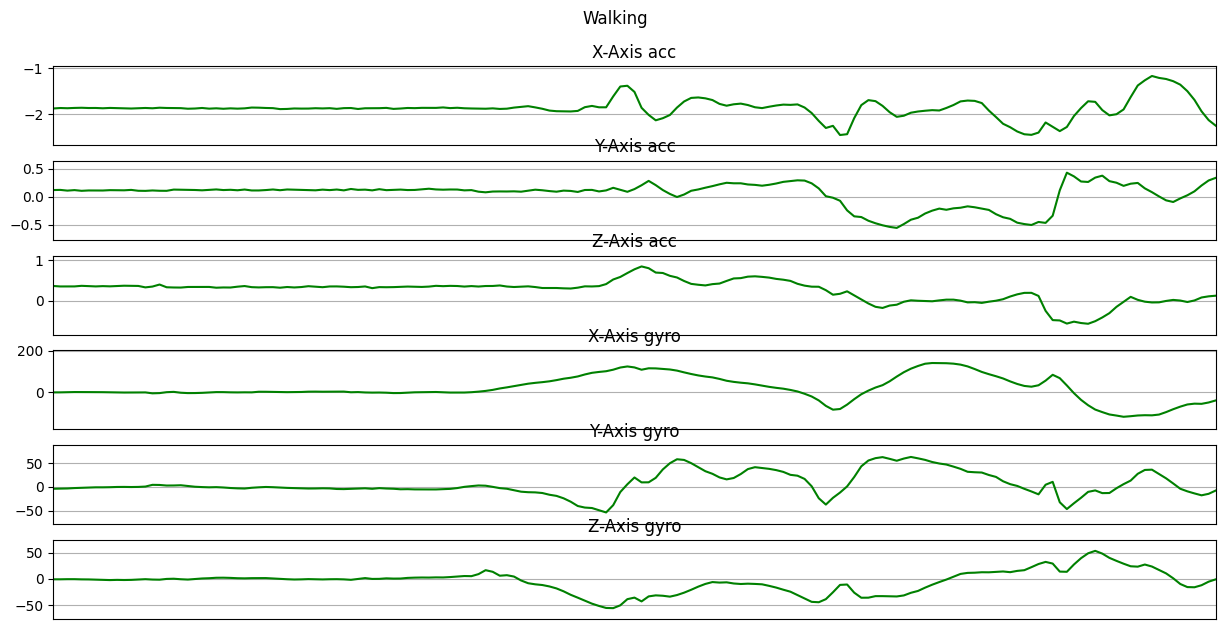

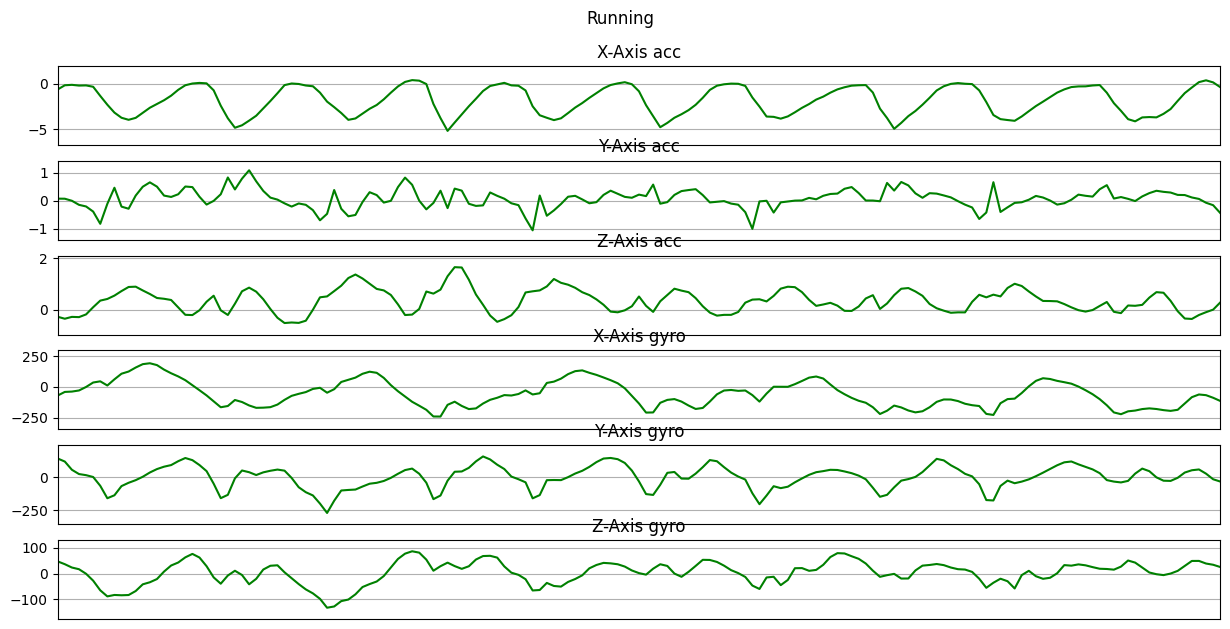

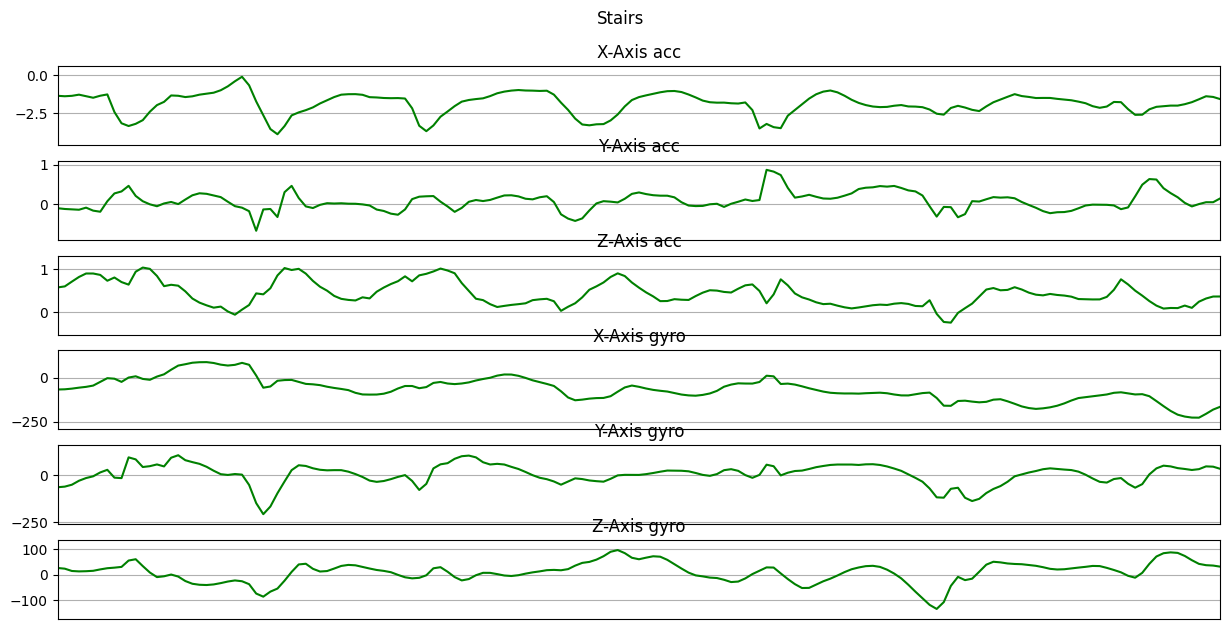

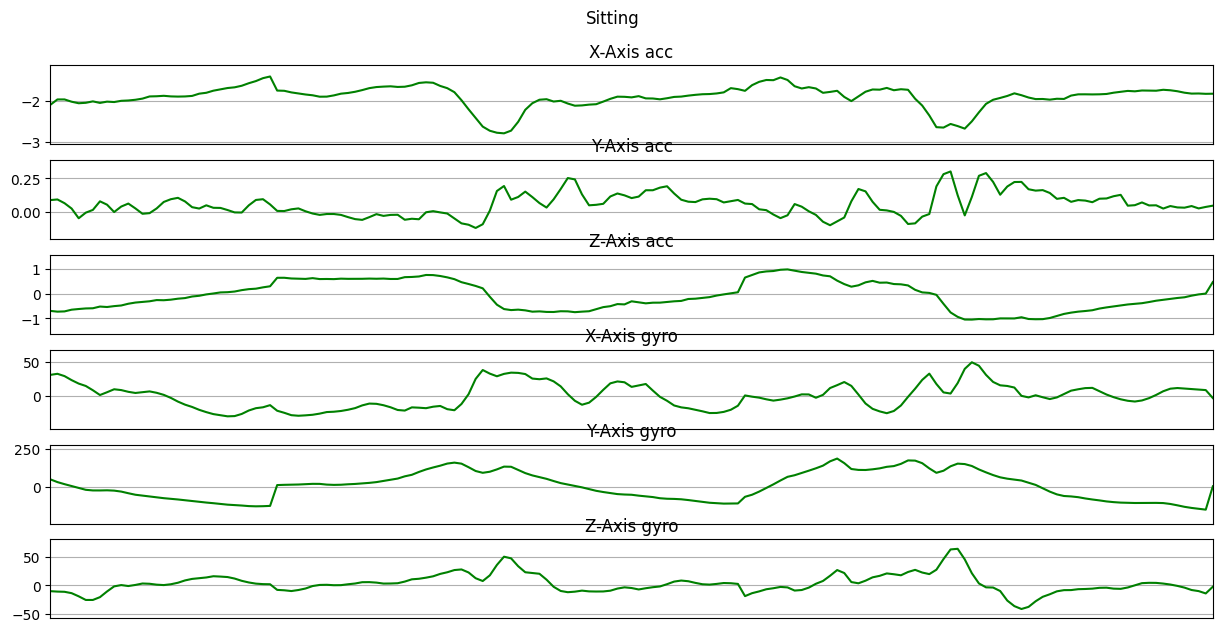

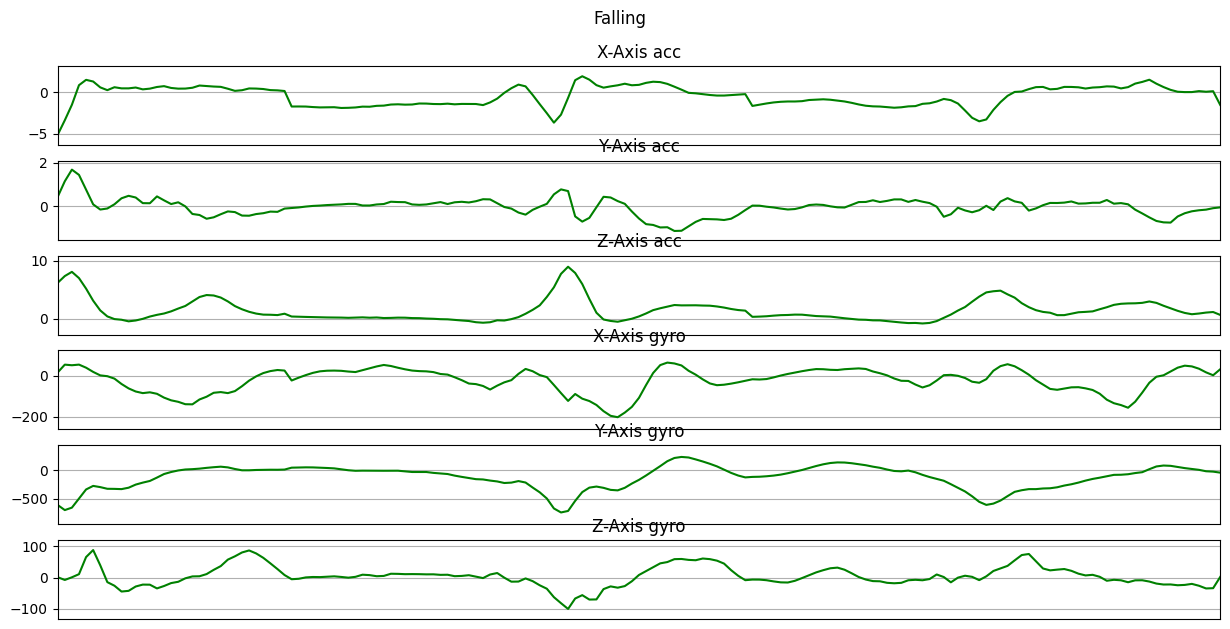

In [12]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
    plot_activity(activity, data_for_plot)

In [13]:
counts = data['label'].value_counts()
counts

label
Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: count, dtype: int64

In [14]:
# calculate weights to balance weights on imbalance classes
# references: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
n_classes = 5
n_total = data.shape[0]

weight_0 = n_total / (n_classes * counts[0]) # 
weight_1 = n_total / (n_classes * counts[1]) #
weight_2 = n_total / (n_classes * counts[2])
weight_3 = n_total / (n_classes * counts[3])
weight_4 = n_total / (n_classes * counts[4])
class_weight = {0: weight_0, 1: weight_1, 2:weight_2, 3: weight_3, 4: weight_4}

/tmp/ipykernel_14798/1200768950.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight_0 = n_total / (n_classes * counts[0]) #
/tmp/ipykernel_14798/1200768950.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight_1 = n_total / (n_classes * counts[1]) #
/tmp/ipykernel_14798/1200768950.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight_2 = n_total / (n_classes * counts[2])
/tmp/ipykernel_14798/1200768950.py:10: Future

In [15]:
class_weight

{0: 0.5609141055949567,
 1: 0.6791984732824428,
 2: 0.8024802705749718,
 3: 3.8475675675675673,
 4: 4.187058823529412}

In [16]:
data.shape

(234894, 7)

In [17]:
data['label'].value_counts()

label
Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: count, dtype: int64

In [18]:
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.896115,0.065920,0.233467,27.588733,-26.734214,4.394665
1,Falling,-1.868648,0.069582,0.218818,24.292734,-31.861324,6.469924
2,Falling,-1.858577,0.041200,0.200507,22.583697,-38.941618,8.789331
3,Falling,-1.847591,0.032044,0.250862,19.531846,-43.458357,11.108737
4,Falling,-1.869564,0.026551,0.271920,16.602069,-48.097171,10.132145


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
234889,Walking,-2.012391,0.450453,0.207831,14.404736,-10.620441,20.020142,4
234890,Walking,-2.122257,0.277413,0.282907,-8.667257,-3.784295,26.001770,4
234891,Walking,-2.005982,0.156560,0.313120,-17.334513,-1.709037,27.466659,4
234892,Walking,-1.810968,0.079653,0.304880,-27.954955,12.573626,20.752586,4
234893,Walking,-1.754204,0.097964,0.302133,-27.222510,14.526811,3.784295,4


In [21]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [22]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,-0.147940,0.145744,-0.288482,0.418518,-0.392026,0.019395,0
1,-0.110983,0.155502,-0.315099,0.381535,-0.468131,0.061890,0
2,-0.097432,0.079876,-0.348370,0.362359,-0.573228,0.109385,0
3,-0.082649,0.055480,-0.256874,0.328117,-0.640273,0.156880,0
4,-0.112214,0.040843,-0.218612,0.295243,-0.709129,0.136882,0
...,...,...,...,...,...,...,...
234889,-0.304393,1.170355,-0.335062,0.270588,-0.152840,0.339361,4
234890,-0.452222,0.709280,-0.198649,0.011712,-0.051367,0.461849,4
234891,-0.295769,0.387259,-0.143751,-0.085538,-0.020563,0.491846,4
234892,-0.033372,0.182337,-0.158723,-0.204703,0.191444,0.354360,4


### Frame Preparation 

In [24]:
import scipy.stats as stats

In [25]:
Fs = 33
frame_size = Fs*2
hop_size = 66

In [26]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size]).mode
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [27]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [28]:
X.shape, y.shape

((3558, 66, 6), (3558,))

In [31]:
# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Second split: Split training data into train and validation (80% of 80% = 64% total for train, 16% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7, stratify=y_train)

# Now you can reshape
X_train = X_train.reshape(X_train.shape[0], 66, 6, 1)
X_val = X_val.reshape(X_val.shape[0], 66, 6, 1)
X_test = X_test.reshape(X_test.shape[0], 66, 6, 1)

In [32]:
X_train.shape, X_val.shape, X_test.shape, 

((2276, 66, 6, 1), (570, 66, 6, 1), (712, 66, 6, 1))

### LSTM

In [33]:
X_train = X_train.reshape(X_train.shape[0], 66, 6)
X_test = X_test.reshape(X_test.shape[0], 66, 6)

In [34]:
model = Sequential()
model.add(LSTM(units=128, input_shape= X_train[0].shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, input_shape= X_train[0].shape, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

I0000 00:00:1736047589.908589   14798 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/adithyan/gptenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, verbose=1, callbacks = [es])

# count the number of epochs after early stopping
number_of_epochs = len(history.history['loss'])

Epoch 1/100


I0000 00:00:1736047602.869711   14999 cuda_dnn.cc:529] Loaded cuDNN version 90501


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5929 - loss: 1.1330 - val_accuracy: 0.8684 - val_loss: 0.3962
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7819 - loss: 0.5612 - val_accuracy: 0.8772 - val_loss: 0.2771
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8404 - loss: 0.4270 - val_accuracy: 0.8991 - val_loss: 0.2781
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8510 - loss: 0.3690 - val_accuracy: 0.8860 - val_loss: 0.2926
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8534 - loss: 0.3523 - val_accuracy: 0.9254 - val_loss: 0.2012
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8807 - loss: 0.3045 - val_accuracy: 0.9386 - val_loss: 0.1750
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8913 - loss: 0.2716 - val_accuracy: 0.9342 - val_loss: 0.1780
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8997 - loss: 0.2368 - val_accuracy: 0.9342 - val_l

In [37]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

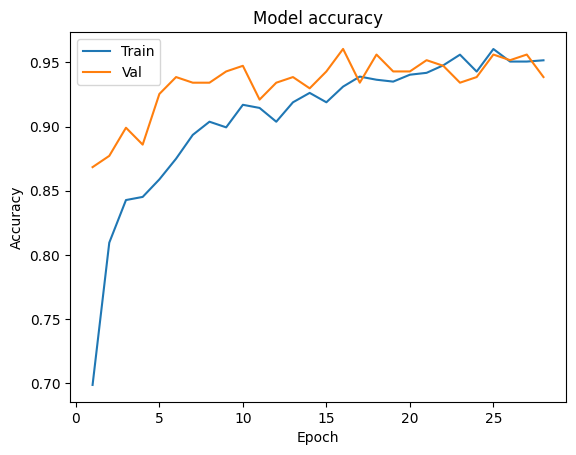

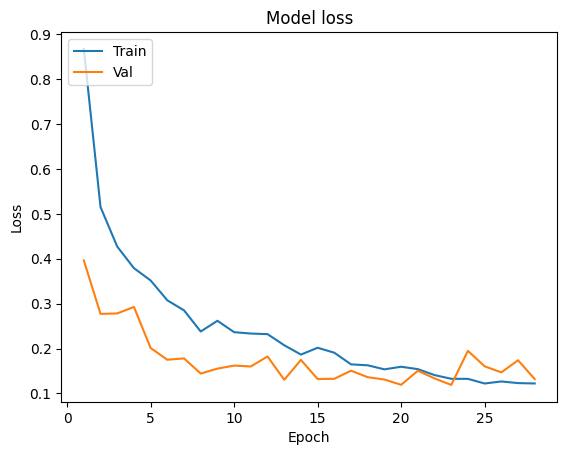

In [38]:
plot_learningCurve(history, number_of_epochs)

### Confusion Matrix 

In [39]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 66, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 66, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       540,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225,297 (8.49 MB)

 Trainable params: 741,765 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,483,532 (5.66 MB)

In [41]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


0.9339887640449438

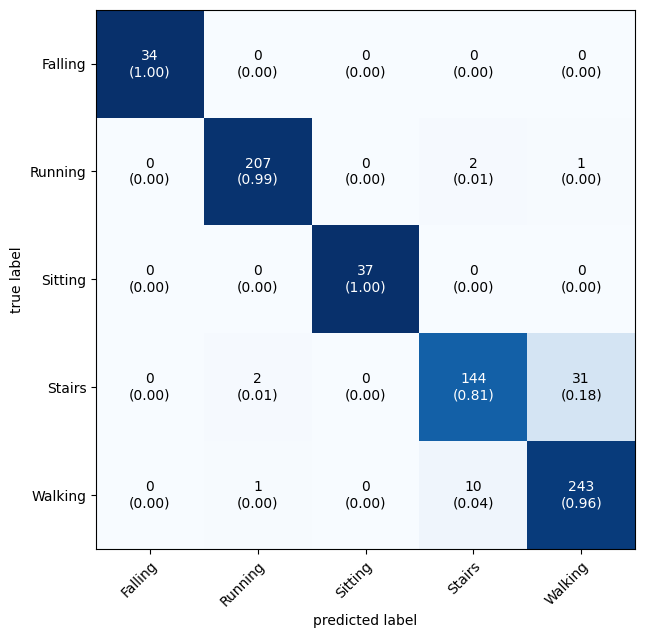

In [42]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [43]:
model.save('models/new/lstm_6_elderly_body.h5')

In [58]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

def prepare_sequence(data, scaler, timestamps=66):
    """
    Prepare a sequence from given data using a fitted scaler.
    
    Parameters:
        data (list): List of sensor data [x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr].
        scaler (StandardScaler): A fitted StandardScaler for scaling the data.
        timestamps (int): Number of time steps in the sequence.
        
    Returns:
        np.array: Sequence reshaped for LSTM input.
    """
    # Scale the data
    scaled_data = scaler.transform(data)
    
    # Create a sequence
    sequence = np.zeros((timestamps, scaled_data.shape[1]))
    for i in range(timestamps):
        noise = np.random.normal(0, 0.01, scaled_data.shape[1])  # Small noise for variety
        sequence[i] = scaled_data[i % len(scaled_data)] + noise  # Repeat data if less than timestamps
    
    return sequence.reshape(1, timestamps, scaled_data.shape[1])

def predict_activity(model_path, data_samples):
    """
    Predict activity for multiple sensor data samples using a trained model.
    
    Parameters:
        model_path (str): Path to the trained Keras model.
        data_samples (list): List of sensor data rows [[x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr], ...].
        
    Returns:
        list: Predicted activity and confidence for each sample.
    """
    # Define activities (update if different in your dataset)
    activities = ['Falling', 'Running', 'Sitting', 'Stairs', 'Walking']
    
    # Load the trained model
    model = load_model(model_path)
    
    # Example training data for fitting scaler (replace with your actual training data)
    training_data = np.array([
        [-1.68553727835932, -0.237128818628498, 0.573137607959227, 86.91671498764, 22.9499191259498, -54.200872829371],
        [-1.59306619464705, -0.436719870601519, -0.511795403912472, -117.313150425733, 7.20236823633533, -36.5001373332926],
        [-2.86294137394329, 0.42939542832728, 0.761741996520889, -75.075533310953, 92.4100466933195, -107.913449507126],
        [-1.847590564, 0.032044435, 0.250862148, 19.53184606, -43.45835749, 11.10873745],
        	
	[-2.33375042,0.146488845,0.153813288,23.07199316,111.5756706,13.42814417],
	[-2.413403729,0.249031037,0.065004425,12.5736259,107.1810053,21.2408826]
    ])
    
    # Initialize and fit the scaler
    scaler = StandardScaler()
    scaler.fit(training_data)
    
    predictions = []
    for sample in data_samples:
        # Prepare the sequence
        sequence = prepare_sequence(np.array([sample]), scaler)
        
        # Predict activity
        pred = model.predict(sequence)
        
        # Get the most likely activity and confidence
        predicted_index = np.argmax(pred)
        confidence = pred[0][predicted_index] * 100
        predicted_activity = activities[predicted_index]
        
        predictions.append((predicted_activity, confidence))
    
    return predictions

# Define the data samples (input your samples here)
data_samples = [
    
    [-0.172124393444624,0.894497512741477,1.71025727103488,-0.244148075807977,-83.9869380779442,83.1324198126163]
]

# Specify the path to your trained model
model_path = 'models/new/lstm_6_elderly_body.h5'

# Run predictions
try:
    results = predict_activity(model_path, data_samples)
    print("Activity Predictions:")
    for i, (activity, confidence) in enumerate(results):
        print(f"Sample {i + 1}: {activity} with confidence {confidence:.2f}%")
except Exception as e:
    print(f"Error: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Activity Predictions:
Sample 1: Falling with confidence 99.99%


In [52]:
from twilio.rest import Client

account_sid = 'ACb4d7d687235b0351c7336c501136b7d2'
auth_token = '9d896feb89b0258552a3ce5ef092215e'
client = Client(account_sid, auth_token)

message = client.messages.create(
  from_='+12185797555',
  body='This is a emergency',
  to='+918111838121'
)

print(message.sid)

SMc0b559c528015639af2dd8253288f7c4
